# Model Training using CNN (r1)

This notebook demonstrates how to train a custom expression classification model (CNN) using TensorFlow and Keras, with CUDA support for GPU acceleration. The model will classify facial expressions into 7 categories: angry, disgust, fear, happy, neutral, sad, and surprise.

## instaling dependency

In [1]:
!pip install tensorflow[and-cuda] Keras NumPy Matplotlib Seaborn Scikit-learn

import and dependency call

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

2024-09-04 16:48:39.080532: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-04 16:48:39.099037: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-04 16:48:39.104696: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-04 16:48:39.117910: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-04 16:48:40.041667: W tensorflow/compiler/tf2

## Data prepocessing

In [3]:
# Set up data paths and parameters
data_dir = './face-expression-recognition-dataset/images/images'
img_height, img_width = 48, 48
batch_size = 64
num_classes = 7

# Data preprocessing function
def preprocess_image(img):
    img = tf.cast(img, tf.float32)
    img = (img / 255.0) - 0.5
    return img

# Data generators
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_image)

train_generator = train_datagen.flow_from_directory(
    f'{data_dir}/train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    f'{data_dir}/validation',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False
)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


## CNN model settings

### definition

In [4]:
# CNN Model Definition
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 1)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

/opt/micromamba/envs/python_310/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-09-04 16:48:43.355918: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1118 MB memory:  -> device: 0, name: NVIDIA RTX 4000 Ada Generation, pci bus id: 0000:c1:00.0, compute capability: 8.9


### model compiler

In [5]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()

# Callbacks
checkpoint = ModelCheckpoint('./models/r1_best_model.keras', save_best_only=True, monitor='val_accuracy', mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weight_dict = dict(enumerate(class_weights))

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 44, 44, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 44, 44, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 20, 20, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 18, 18, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 5, 5, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 5, 5, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 556,519 (2.12 MB)

 Trainable params: 554,599 (2.12 MB)

 Non-trainable params: 1,920 (7.50 KB)

### train model

In [6]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=(train_generator.samples + batch_size - 1) // batch_size,  # Rounding up to include all data
    epochs=77,
    validation_data=validation_generator,
    validation_steps=max(1, validation_generator.samples // batch_size),  # Ensure at least 1 validation step
    callbacks=[checkpoint, early_stopping, reduce_lr],
    class_weight=class_weight_dict,
    shuffle=True
)

Epoch 1/77


/opt/micromamba/envs/python_310/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1725468532.129942   11059 service.cc:146] XLA service 0x7f7d9c01d460 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725468532.129997   11059 service.cc:154]   StreamExecutor device (0): NVIDIA RTX 4000 Ada Generation, Compute Capability 8.9
2024-09-04 16:48:52.272989: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-04 16:48:52.745353: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 890

  1/451 ━━━━━━━━━━━━━━━━━━━━ 1:45:59 14s/step - accuracy: 0.1250 - loss: 3.8714

I0000 00:00:1725468539.269600   11059 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


451/451 ━━━━━━━━━━━━━━━━━━━━ 270s 570ms/step - accuracy: 0.1537 - loss: 2.7113 - val_accuracy: 0.1578 - val_loss: 1.9306 - learning_rate: 0.0010
Epoch 2/77


2024-09-04 16:53:15.576800: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-04 16:53:15.576871: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]
2024-09-04 16:53:15.576911: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18345216736944974392
/opt/micromamba/envs/python_310/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


451/451 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 2.4548 - learning_rate: 0.0010
Epoch 3/77


2024-09-04 16:53:16.327258: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


451/451 ━━━━━━━━━━━━━━━━━━━━ 240s 527ms/step - accuracy: 0.1557 - loss: 2.0815 - val_accuracy: 0.2268 - val_loss: 1.8719 - learning_rate: 0.0010
Epoch 4/77
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.4231 - val_loss: 1.6200 - learning_rate: 0.0010
Epoch 5/77


2024-09-04 16:57:16.769759: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4329205386652012881
2024-09-04 16:57:16.769819: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18345216736944974392
2024-09-04 16:57:16.778382: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


451/451 ━━━━━━━━━━━━━━━━━━━━ 233s 512ms/step - accuracy: 0.1701 - loss: 2.0021 - val_accuracy: 0.1896 - val_loss: 1.8971 - learning_rate: 0.0010
Epoch 6/77


2024-09-04 17:01:09.942486: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4329205386652012881
2024-09-04 17:01:09.942519: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18345216736944974392
2024-09-04 17:01:10.094591: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5484063994925768569
2024-09-04 17:01:10.094653: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18345216736944974392


451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7308 - val_loss: 1.3719 - learning_rate: 0.0010
Epoch 7/77
451/451 ━━━━━━━━━━━━━━━━━━━━ 236s 517ms/step - accuracy: 0.1847 - loss: 1.9172 - val_accuracy: 0.2297 - val_loss: 1.8327 - learning_rate: 0.0010
Epoch 8/77
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5769 - val_loss: 1.3723 - learning_rate: 0.0010
Epoch 9/77


2024-09-04 17:05:05.796970: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4329205386652012881
2024-09-04 17:05:05.797006: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18345216736944974392
2024-09-04 17:05:05.952636: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


451/451 ━━━━━━━━━━━━━━━━━━━━ 230s 505ms/step - accuracy: 0.2020 - loss: 1.8868 - val_accuracy: 0.1881 - val_loss: 1.9125 - learning_rate: 0.0010
Epoch 10/77
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7308 - val_loss: 0.9764 - learning_rate: 0.0010
Epoch 11/77


2024-09-04 17:08:55.774831: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4329205386652012881
2024-09-04 17:08:55.774874: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18345216736944974392


451/451 ━━━━━━━━━━━━━━━━━━━━ 227s 499ms/step - accuracy: 0.2146 - loss: 1.8741 - val_accuracy: 0.2271 - val_loss: 1.8762 - learning_rate: 0.0010
Epoch 12/77


2024-09-04 17:12:43.398993: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4329205386652012881
2024-09-04 17:12:43.399033: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18345216736944974392


451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8846 - val_loss: 0.7183 - learning_rate: 0.0010
Epoch 13/77
451/451 ━━━━━━━━━━━━━━━━━━━━ 229s 502ms/step - accuracy: 0.2303 - loss: 1.8447 - val_accuracy: 0.2898 - val_loss: 1.7916 - learning_rate: 0.0010
Epoch 14/77
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8077 - val_loss: 0.8405 - learning_rate: 0.0010
Epoch 15/77


2024-09-04 17:16:32.657252: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4329205386652012881
2024-09-04 17:16:32.657298: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18345216736944974392


451/451 ━━━━━━━━━━━━━━━━━━━━ 221s 486ms/step - accuracy: 0.2523 - loss: 1.8268 - val_accuracy: 0.3274 - val_loss: 1.7003 - learning_rate: 0.0010
Epoch 16/77


2024-09-04 17:20:14.096014: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4329205386652012881
2024-09-04 17:20:14.096053: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18345216736944974392
2024-09-04 17:20:14.247572: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9615 - val_loss: 0.4544 - learning_rate: 0.0010
Epoch 17/77
451/451 ━━━━━━━━━━━━━━━━━━━━ 226s 497ms/step - accuracy: 0.2682 - loss: 1.7768 - val_accuracy: 0.3506 - val_loss: 1.7094 - learning_rate: 0.0010
Epoch 18/77
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9231 - val_loss: 0.4153 - learning_rate: 0.0010
Epoch 19/77


2024-09-04 17:24:00.625645: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4329205386652012881
2024-09-04 17:24:00.625690: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18345216736944974392


451/451 ━━━━━━━━━━━━━━━━━━━━ 232s 508ms/step - accuracy: 0.3097 - loss: 1.7579 - val_accuracy: 0.3986 - val_loss: 1.5859 - learning_rate: 0.0010
Epoch 20/77
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8846 - val_loss: 0.4054 - learning_rate: 0.0010
Epoch 21/77
451/451 ━━━━━━━━━━━━━━━━━━━━ 232s 510ms/step - accuracy: 0.3251 - loss: 1.7224 - val_accuracy: 0.4281 - val_loss: 1.4948 - learning_rate: 0.0010
Epoch 22/77
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8462 - val_loss: 0.6309 - learning_rate: 0.0010
Epoch 23/77


2024-09-04 17:31:45.059748: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4329205386652012881
2024-09-04 17:31:45.059785: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18345216736944974392
2024-09-04 17:31:45.242272: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5484063994925768569
2024-09-04 17:31:45.242321: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18345216736944974392


451/451 ━━━━━━━━━━━━━━━━━━━━ 238s 523ms/step - accuracy: 0.3433 - loss: 1.6787 - val_accuracy: 0.4500 - val_loss: 1.4596 - learning_rate: 0.0010
Epoch 24/77
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8846 - val_loss: 0.5106 - learning_rate: 0.0010
Epoch 25/77


2024-09-04 17:35:43.585255: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4329205386652012881
2024-09-04 17:35:43.585294: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18345216736944974392


451/451 ━━━━━━━━━━━━━━━━━━━━ 237s 520ms/step - accuracy: 0.3698 - loss: 1.6325 - val_accuracy: 0.3814 - val_loss: 1.6622 - learning_rate: 0.0010
Epoch 26/77
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8077 - val_loss: 0.6373 - learning_rate: 2.0000e-04
Epoch 27/77
451/451 ━━━━━━━━━━━━━━━━━━━━ 227s 497ms/step - accuracy: 0.3934 - loss: 1.5548 - val_accuracy: 0.4773 - val_loss: 1.3909 - learning_rate: 2.0000e-04
Epoch 28/77
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9615 - val_loss: 0.4819 - learning_rate: 2.0000e-04
Epoch 29/77
451/451 ━━━━━━━━━━━━━━━━━━━━ 220s 484ms/step - accuracy: 0.4150 - loss: 1.5135 - val_accuracy: 0.4864 - val_loss: 1.3497 - learning_rate: 2.0000e-04
Epoch 30/77
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9615 - val_loss: 0.4740 - learning_rate: 2.0000e-04


2024-09-04 17:47:07.905092: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4329205386652012881
2024-09-04 17:47:07.905125: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18345216736944974392


### training history

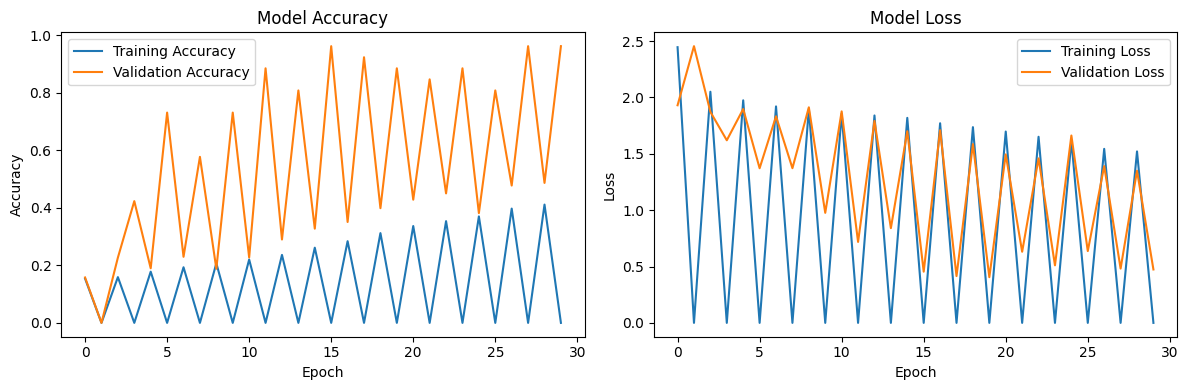

In [7]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### model evaluation

In [8]:
# Evaluate the model
test_generator = validation_datagen.flow_from_directory(
    f'{data_dir}/validation',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False
)

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy:.2f}")
print(f"Test loss: {test_loss:.2f}")

Found 7066 images belonging to 7 classes.
111/111 ━━━━━━━━━━━━━━━━━━━━ 23s 206ms/step - accuracy: 0.2933 - loss: 1.8203
Test accuracy: 0.40
Test loss: 1.58


### Generate predictions

In [9]:
# Generate predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

111/111 ━━━━━━━━━━━━━━━━━━━━ 25s 218ms/step


### Confusion matrix

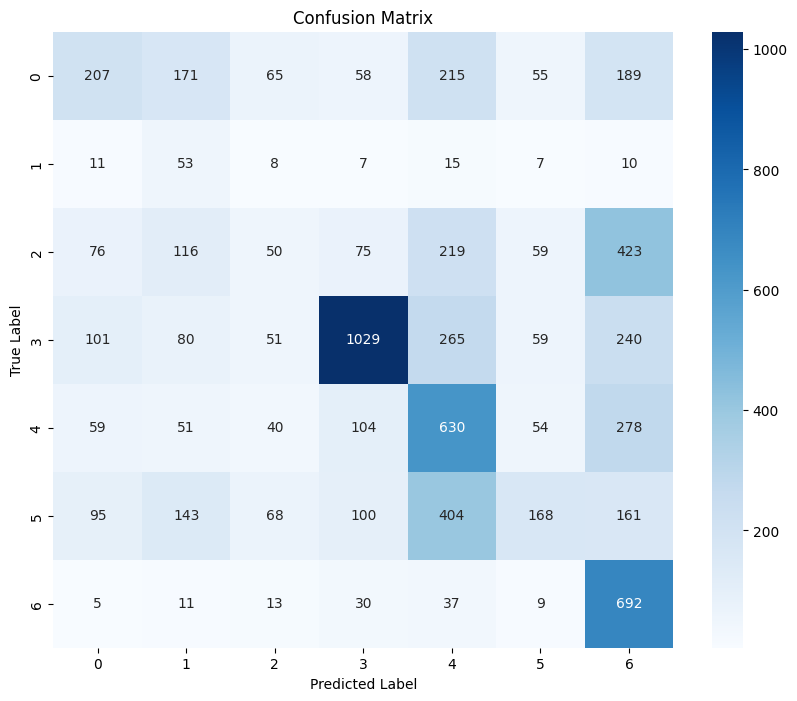

In [10]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Classification report

In [11]:
# Classification report
class_names = list(train_generator.class_indices.keys())
print(classification_report(y_true, y_pred_classes, target_names=class_names))

              precision    recall  f1-score   support

       angry       0.37      0.22      0.27       960
     disgust       0.08      0.48      0.14       111
        fear       0.17      0.05      0.08      1018
       happy       0.73      0.56      0.64      1825
     neutral       0.35      0.52      0.42      1216
         sad       0.41      0.15      0.22      1139
    surprise       0.35      0.87      0.50       797

    accuracy                           0.40      7066
   macro avg       0.35      0.41      0.32      7066
weighted avg       0.43      0.40      0.38      7066



### Save the model

In [12]:
# Save the model
model.save('./models/r1_expression_classification_model.keras')
print("Model saved as 'r1_expression_classification_model.keras'")

Model saved as 'r1_expression_classification_model.keras'
